In [11]:
import os
import sys

import numpy as np
from fontTools.misc.psOperators import ps_name
from torch import tensor, nn, Tensor
import torch
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.tensorboard import SummaryWriter

sys.path.append(os.path.abspath(r'../../'))

from src.utils.common import get_model_resnet18_cifar10, get_loader, create_saved_data_dir, get_device, save, load
from src.utils.dataset import get_cifar, GPUDataset
from src.utils.plot import plot_loss_acc, plot_img_and_top
from src.utils.train import ModelManager, Mode
from src.config import PATH_SAVE_MODELS, PATH_DATASETS, PATH_LOGS

# globals
NUM_CLASSES = 100
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
EPOCHS = 100

DEVICE = get_device()

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_ordered, dataset_train_raw = get_cifar(PATH_DATASETS)
loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, False)
loader_train_ordered = get_loader(dataset_train_ordered, train_idx, BATCH_SIZE, False)

Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

# get prune scores
data = torch.load(os.path.join(PATH_SAVE_MODELS, 'el2n', 'general.pt'))

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(os.path.join(PATH_SAVE_MODELS, 'forgetting', 'other.pt'))['change_counter']

# idx_sorted_el2n = torch.arange(NUM_TRAIN)
# idx_sorted_forgetting = torch.arange(NUM_TRAIN)
# idx_sorted_std = torch.arange(NUM_TRAIN)
# ensemble_std = torch.arange(NUM_TRAIN)
# idx_sorted_pred_sum = torch.arange(NUM_TRAIN)
# idx_random_prune = torch.arange(NUM_TRAIN)

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)


CUDA is available!  Training on  GPU...
Files already downloaded and verified
Files already downloaded and verified


In [12]:
idx_sorted = {
    'el2n': idx_sorted_el2n,
    'forget': idx_sorted_forgetting,
    'std': idx_sorted_std,
    'pred_sum': idx_sorted_pred_sum,
    'random': idx_random_prune
}

regular_model = ModelManager(NUM_CLASSES, 'no_prune', dir_='prune_25p', load=True)
models = [regular_model]

prune_sizes = [.1, .2, .3, .4, .5, .6, .7]
acc_test: dict[str:dict[float:float]] = {'no_prune': {p: regular_model.data['test']['acc'] for p in prune_sizes}}

print()
for name, idx in idx_sorted.items():
    acc_test[name] = {}
    for prune_size in prune_sizes:
        # if name in ['el2n', 'std', 'forget']:
        #     continue

        print(f'====     train model with {prune_size:.0%} prune according to {name} most hard     ======')
        num_train = int(NUM_TRAIN * (1. - prune_size))
        # print(idx[-num_train:])
        loader_train = get_loader(dataset_train, idx[-num_train:], BATCH_SIZE, True)

        model_manager = ModelManager(NUM_CLASSES, f'prune_1To7p_{name}_{int(prune_size * 10)}', dir_='prune_1To7p',
                                     load=False)
        model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
        acc_test[name][prune_size] = model_manager.data['test']['acc']
        # print(num_train, acc_test[name][prune_size])

        models.append(model_manager)
        print()


====     train model with 10% prune according to el2n most hard     ======
Epoch: 0 Training: Loss: 0.159432 Acc: 0.076133  Validation Loss: 0.148754 Acc: 0.106400                                                   
Validation loss decreased (inf --> 0.148754).  Saving model to models_data/prune_1To7p\prune_1To7p_el2n_1
Epoch: 1 Training: Loss: 0.141683 Acc: 0.131156  Validation Loss: 0.126177 Acc: 0.192100                                                    
Validation loss decreased (0.148754 --> 0.126177).  Saving model to models_data/prune_1To7p\prune_1To7p_el2n_1
Epoch: 2 Training: Loss: 0.129144 Acc: 0.182578  Validation Loss: 0.112185 Acc: 0.259600                                                    
Validation loss decreased (0.126177 --> 0.112185).  Saving model to models_data/prune_1To7p\prune_1To7p_el2n_1
Epoch: 3 Training: Loss: 0.119278 Acc: 0.226622  Validation Loss: 0.109365 Acc: 0.288200                                                    
Validation loss decreased (0.1121

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000241A26257E0>
Traceback (most recent call last):
  File "C:\Users\ProjectUser\Documents\Data-pruning\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\ProjectUser\Documents\Data-pruning\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\ProjectUser\Documents\Python3_10_9\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Users\ProjectUser\Documents\Python3_10_9\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


Epoch 81 Train: █████████████████████████████████████████████████▊            664/800 [00:51<00:07, 18.22 batch/s, acc=71.30%, loss=0.016]

KeyboardInterrupt: 

In [13]:
# tb = SummaryWriter(log_dir=os.path.join(PATH_LOGS, 'prune_1To7p', 'models', 'progress_.pt'))
# for i in range(len([])):
#     tb.add_scalars('models_acc',
#                    {prune_method: acc_test[prune_method][prune_sizes[i]] for prune_method, acc in acc_test}, i)
# tb.close()

KeyError: 0.6

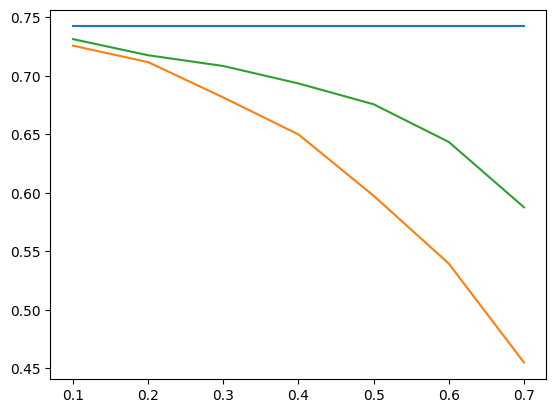

In [16]:
# ModelManager.save_models_log(models, 'prune_1To7p')

# [model.name for model in models]

for prune_method in acc_test:
    if prune_method in ['el2n', 'forget','no_prune']:
        plt.plot(prune_sizes, [acc_test[prune_method][p] for p in prune_sizes], label=prune_method)
    if prune_method =='std':
         plt.plot(prune_sizes, [acc_test[prune_method][p] for p in prune_sizes], label=prune_method)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()